# Step 1: Import Necessary Libraries

In [13]:
# Import necessary libraries for TensorFlow and data processing
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight


# Step 2: Declare the path to dataset

In [14]:
local_path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"

# Step 3: Load and Split the Dataset
We will now load the images into TensorFlow and split them into training and validation sets using image_dataset_from_directory.

The dataset is split into training (80%) and validation (20%) sets.
The class labels (benign, malignant, normal) are inferred automatically from the folder structure.

In [15]:
# Define image size and batch size
img_height = 500
img_width = 500
batch_size = 32

# Load the dataset from the local directory (with automatic label assignment from folders)
train_ds = image_dataset_from_directory(
    local_path,  # Local path to the image dataset
    image_size=(img_height, img_width),  # Resize all images to 500x500
    batch_size=batch_size,
    label_mode='categorical',  # Automatically label based on folder names
    validation_split=0.2,  # 80% training, 20% validation
    subset="training",  # Specify that this is the training set
    seed=123  # Seed for reproducibility
)

val_ds = image_dataset_from_directory(
    local_path,  # Local path to the image dataset
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",  # Specify that this is the validation set
    seed=123
)

# Check class names to ensure correct label mapping
class_names = train_ds.class_names
print(f'Class names: {class_names}')  # Output: ['benign', 'malignant', 'normal']


Found 1578 files belonging to 3 classes.
Using 1263 files for training.
Found 1578 files belonging to 3 classes.
Using 315 files for validation.
Class names: ['benign', 'malignant', 'normal']


# Step 4: Data Preprocessing
## a) Data Augmentation
We apply data augmentation (random transformations) to prevent overfitting and improve model generalization.

In [16]:
# Create a data augmentation pipeline using Keras Sequential API
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # Flip images horizontally
    layers.RandomRotation(0.2),       # Rotate images by 20%
    layers.RandomZoom(0.2),           # Zoom images randomly by 20%
    layers.RandomBrightness(0.2)      # Randomly adjust brightness
])

# Apply augmentation to the training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


## b) Resizing and Rescaling
Resize all images to the same size and rescale pixel values to the range [0, 1] for faster convergence.

In [17]:
# Resizing layer (optional since we specify image size in image_dataset_from_directory)
resizing_layer = layers.Resizing(img_height, img_width)

# Rescaling layer to normalize pixel values (0-255 to 0-1)
normalization_layer = layers.Rescaling(1./255)

# Apply resizing and normalization to both training and validation datasets
train_ds = train_ds.map(lambda x, y: (resizing_layer(x), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

val_ds = val_ds.map(lambda x, y: (resizing_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


# Step 5: Handle Class Imbalance
Calculate and apply class weights to give more importance to under-represented classes.

We calculate the class weights based on the number of images in each class.
The class weights are used later during model training to handle imbalance.

In [18]:
# Count of images in each class (based on folder structure)
class_counts = [891, 421, 266]  # Number of images in 'benign', 'malignant', 'normal'
total_images = np.sum(class_counts)

# Calculate class weights to handle imbalance (higher weight for under-represented classes)
class_weight = {
    0: total_images / (3 * class_counts[0]),  # benign
    1: total_images / (3 * class_counts[1]),  # malignant
    2: total_images / (3 * class_counts[2])   # normal
}

# Print the calculated class weights
print(f"Class weights: {class_weight}")


Class weights: {0: 0.590347923681257, 1: 1.2494061757719714, 2: 1.9774436090225564}


# Step 6: Build the CNN Model
We build a convolutional neural network (CNN) model using Keras.

In [19]:
# Build the CNN model using the Keras Sequential API
model = models.Sequential([
    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),  # Flatten the feature map to pass into fully connected layers
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(3, activation='softmax')  # Output layer (3 classes)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
    metrics=['accuracy']
)

# Display the model architecture
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 498, 498, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 249, 249, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 247, 247, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 123, 123, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 121, 121, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 460800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    58,982,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,076,163 (225.36 MB)

 Trainable params: 59,076,163 (225.36 MB)

 Non-trainable params: 0 (0.00 B)

# Step 7: Train the Model
Train the model using the training data, validation data, and class weights.

We pass *class_weight* to ensure the model compensates for the class imbalance.
The model is trained for 20 epochs, but you can be adjusted based on performance.

In [20]:
# Train the model using the training data and validate on the validation data
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=20,  # Number of epochs to train for
    class_weight=class_weight,  # Pass in class weights to handle imbalance
    verbose=2  # Print progress of training
)


Epoch 1/20
40/40 - 77s - 2s/step - accuracy: 0.4743 - loss: 1.2101 - val_accuracy: 0.5143 - val_loss: 0.9786
Epoch 2/20
40/40 - 73s - 2s/step - accuracy: 0.4830 - loss: 0.9862 - val_accuracy: 0.4762 - val_loss: 0.9667
Epoch 3/20
40/40 - 73s - 2s/step - accuracy: 0.5313 - loss: 0.9571 - val_accuracy: 0.4857 - val_loss: 0.9856
Epoch 4/20
40/40 - 74s - 2s/step - accuracy: 0.4933 - loss: 0.9284 - val_accuracy: 0.5778 - val_loss: 0.9258
Epoch 5/20
40/40 - 73s - 2s/step - accuracy: 0.4988 - loss: 0.9270 - val_accuracy: 0.5048 - val_loss: 0.9291
Epoch 6/20
40/40 - 74s - 2s/step - accuracy: 0.5012 - loss: 0.9226 - val_accuracy: 0.4825 - val_loss: 0.9380
Epoch 7/20
40/40 - 73s - 2s/step - accuracy: 0.4885 - loss: 0.9117 - val_accuracy: 0.5143 - val_loss: 0.9162
Epoch 8/20
40/40 - 75s - 2s/step - accuracy: 0.5162 - loss: 0.9198 - val_accuracy: 0.5429 - val_loss: 0.9644
Epoch 9/20
40/40 - 73s - 2s/step - accuracy: 0.4814 - loss: 1.0274 - val_accuracy: 0.5556 - val_loss: 0.8988
Epoch 10/20
40/40 -

# Step 8: Evaluate the Model
After training, evaluate the model on the validation data.

In [21]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(val_ds)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.5577 - loss: 0.8388
Validation Loss: 0.8302716016769409
Validation Accuracy: 0.5555555820465088


# Step 9: Save the Model
Finally, save the trained model for future use.

In [22]:
# Save the trained model to a file
model.save('breast_cancer_cnn_model2.h5')

# Visualizing Training Performance

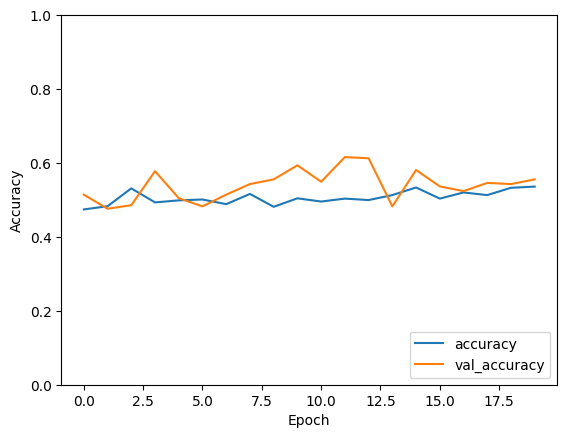

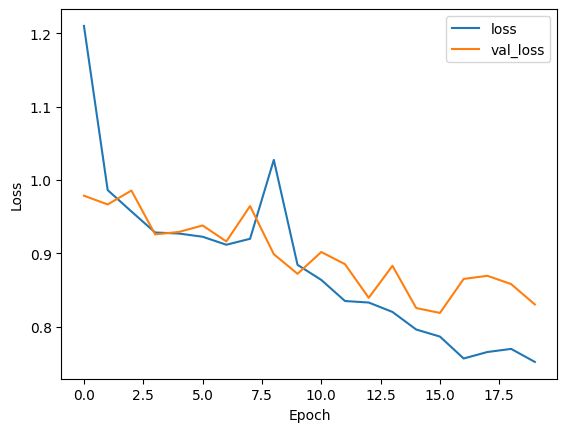

In [23]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()